In [2]:
import os
import sys
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

sys.path.append('..')
from semilearn.core.utils import get_net_builder, get_dataset, over_write_args_from_file
from semilearn.algorithms.openmatch.openmatch import OpenMatchNet
from semilearn.algorithms.iomatch.iomatch import IOMatchNet

In [3]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--c', type=str, default='')

def load_model_at(step='best'):
    args.step = step
    if step == 'best':
        args.load_path = '/'.join(args.load_path.split('/')[1:-1]) + "/model_best.pth"
    if step == 'latest':
        #args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/model_at_{args.step}_step.pth"
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/latest_model.pth"
    else:
        args.load_path = '/'.join(args.load_path.split('/')[:-1]) + "/"+str(step)+"_model.pth"
        
    print(args.load_path)
    checkpoint_path = os.path.join(args.load_path)
    checkpoint = torch.load(checkpoint_path)
    load_model = checkpoint['ema_model']
    load_state_dict = {}
    for key, item in load_model.items():
        if key.startswith('module'):
            new_key = '.'.join(key.split('.')[1:])
            load_state_dict[new_key] = item
        else:
            load_state_dict[key] = item
    save_dir = '/'.join(checkpoint_path.split('/')[:-1])
    if step == 'best':
        args.save_dir = os.path.join(save_dir, f"model_best")
    else:
        args.save_dir = os.path.join(save_dir, f"step_{args.step}")
    os.makedirs(args.save_dir, exist_ok=True)
    _net_builder = get_net_builder(args.net, args.net_from_name)
    net = _net_builder(num_classes=args.num_classes)
    if args.algorithm == 'openmatch':
        net = OpenMatchNet(net, args.num_classes)
    elif args.algorithm == 'iomatch':
        net = IOMatchNet(net, args.num_classes)
    else:
        raise NotImplementedError
    keys = net.load_state_dict(load_state_dict)
    print(f'Model at step {args.step} loaded!')
    if torch.cuda.is_available():
        net.cuda()
    net.eval()
    
    return net

In [4]:
def evaluate_open(net, dataset_dict, num_classes, extended_test=False):
    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    y_pred_closed_list = []
    y_pred_ova_list = []
    
    results = {}
    
    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']

            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()

            num_batch = y.shape[0]
            total_num += num_batch
            
            out = net(x)
            logits, logits_open = out['logits'], out['logits_open']    
            pred_closed = logits.data.max(1)[1]
            
            probs = F.softmax(logits, 1)
            probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
            unk_score = probs_open[tmp_range, 0, pred_closed]
            pred_open = pred_closed.clone()
            pred_open[unk_score > 0.5] = num_classes

            y_true_list.extend(y.cpu().tolist())
            y_pred_closed_list.extend(pred_closed.cpu().tolist())
            y_pred_ova_list.extend(pred_open.cpu().tolist())

    y_true = np.array(y_true_list)

    closed_mask = y_true < num_classes
    open_mask = y_true >= num_classes
    y_true[open_mask] = num_classes

    y_pred_closed = np.array(y_pred_closed_list)
    y_pred_ova = np.array(y_pred_ova_list)

    # Closed Accuracy on Closed Test Data
    y_true_closed = y_true[closed_mask]
    y_pred_closed = y_pred_closed[closed_mask]
    closed_acc = accuracy_score(y_true_closed, y_pred_closed)
    closed_cfmat = confusion_matrix(y_true_closed, y_pred_closed, normalize='true')
    results['c_acc_c_p'] = closed_acc
    results['c_cfmat_c_p'] = closed_cfmat  

    # Open Accuracy on Full Test Data
    open_acc = balanced_accuracy_score(y_true, y_pred_ova)
    open_cfmat = confusion_matrix(y_true, y_pred_ova)
    results['o_acc_f_hq'] = open_acc  
    results['o_cfmat_f_hq'] = open_cfmat
        
    if extended_test:
        with torch.no_grad():
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()

                num_batch = y.shape[0]
                total_num += num_batch

                out = net(x)
                logits, logits_open = out['logits'], out['logits_open']    
                pred_closed = logits.data.max(1)[1]

                probs = F.softmax(logits, 1)
                probs_open = F.softmax(logits_open.view(logits_open.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_open.size(0)).long().cuda()
                unk_score = probs_open[tmp_range, 0, pred_closed]
                pred_open = pred_closed.clone()
                pred_open[unk_score > 0.5] = num_classes

                y_true_list.extend(y.cpu().tolist())
                y_pred_closed_list.extend(pred_closed.cpu().tolist())
                y_pred_ova_list.extend(pred_open.cpu().tolist())
            
        y_true = np.array(y_true_list)

        open_mask = y_true >= num_classes
        y_true[open_mask] = num_classes
        y_pred_ova = np.array(y_pred_ova_list)
        
        # Open Accuracy on Extended Test Data
        open_acc = balanced_accuracy_score(y_true, y_pred_ova)
        open_cfmat = confusion_matrix(y_true, y_pred_ova, normalize='true')
        results['o_acc_e_hq'] = open_acc  
        results['o_cfmat_e_hq'] = open_cfmat
    
    print(f"#############################################################\n"
              f" Closed Accuracy on Closed Test Data: {results['c_acc_c_p'] * 100:.2f}\n"
              f" Open Accuracy on Full Test Data:     {results['o_acc_f_hq'] * 100:.2f}\n"
              #f" Open Accuracy on Extended Test Data: {results['o_acc_e_hq'] * 100:.2f}\n"
              f"#############################################################\n"
        )
    
    return results

In [5]:
def evaluate_io(args, net, dataset_dict, extended_test=False):
    """
    evaluation function for open-set SSL setting
    """

    full_loader = DataLoader(dataset_dict['test']['full'], batch_size=256, drop_last=False, shuffle=False, num_workers=1)
    if extended_test:
        extended_loader = DataLoader(dataset_dict['test']['extended'], batch_size=1024, drop_last=False, shuffle=False, num_workers=4)

    total_num = 0.0
    y_true_list = []
    p_list = []
    pred_p_list = []
    pred_hat_q_list = []
    pred_q_list = []
    pred_q_prob_list=[]
    pred_hat_p_list = []

    with torch.no_grad():
        for data in tqdm(full_loader):
            x = data['x_lb']
            y = data['y_lb']
            #print('y',len(y),y)
            
            if isinstance(x, dict):
                x = {k: v.cuda() for k, v in x.items()}
            else:
                x = x.cuda()
            y = y.cuda()
            y_true_list.extend(y.cpu().tolist())

            num_batch = y.shape[0]
            total_num += num_batch

            outputs = net(x)
            logits = outputs['logits']
            logits_mb = outputs['logits_mb']
            logits_open = outputs['logits_open']

            # predictions p of closed-set classifier
            p = F.softmax(logits, 1)
            pred_p = p.data.max(1)[1]
            pred_p_list.extend(pred_p.cpu().tolist())

            # predictions hat_q from (closed-set + multi-binary) classifiers
            r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
            tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
            hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
            o_neg = r[tmp_range, 0, :]
            o_pos = r[tmp_range, 1, :]
            hat_q[:, :args.num_classes] = p * o_pos
            hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
            pred_hat_q = hat_q.data.max(1)[1]
            pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

            # predictions q of open-set classifier
            q = F.softmax(logits_open, 1)
            pred_q = q.data.max(1)[1]
            #print('p',p[0],'o_pos',o_pos[0])
            #print('q.data',q.data[0:10])
            #print('hatq.data',hat_q.data[0:10])
            #print('pred_q',pred_q)
            pred_q_prob = q.data
            pred_q_list.extend(pred_q.cpu().tolist())
            pred_q_prob_list.extend(pred_q_prob)

            # prediction hat_p of open-set classifier
            hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
            pred_hat_p = hat_p.data.max(1)[1]
            pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

        y_true = np.array(y_true_list)
        #print('y_true',len(y_true),y_true)
        closed_mask = y_true < args.num_classes
        open_mask = y_true >= args.num_classes
        #y_true[open_mask] = args.num_classes
        #print('pred_q[censys_index]',pred_q[censys_index])

        pred_p = np.array(pred_p_list)
        pred_hat_p = np.array(pred_hat_p_list)
        pred_q = np.array(pred_q_list)
        pred_hat_q = np.array(pred_hat_q_list)
        
        # closed accuracy of p / hat_p on closed test data
        c_acc_c_p = accuracy_score(y_true[closed_mask], pred_p[closed_mask])
        c_acc_c_hp = accuracy_score(y_true[closed_mask], pred_hat_p[closed_mask])
        
        set_label =  ['adscore',
 'ahrefs',
 'arbor',
 'archive',
 'binaryedge',

 'criminalip',
 'cybergreen',

 'fofa',
 'internet_census',
 'internettl',
 'intrinsec',
 'ipip',
 'leakix',
 'onyphe',
 'quadmetrics',
 'quake',
 'rapid7',
 'rau',
 'shadowserver',
 'shodan',
 'stretchoid',
 'tum',
 'webRay',
 'x_threatbook',
 'zoomeye',
'driftnet(added in unknown)',
 'unknown',
 'censys(added in unknown)'                     ]
 
        c_cfmat_c_p = confusion_matrix(y_true[closed_mask], pred_p[closed_mask])
        
        
        
        #print('y_true[closed_mask]',y_true[closed_mask])
        #print('pred_hat_p[closed_mask]',pred_hat_p[closed_mask])
        c_cfmat_c_hp = confusion_matrix(y_true[closed_mask], pred_hat_p[closed_mask], normalize='true')
        np.set_printoptions(precision=3, suppress=True)

        # open accuracy of q / hat_q on full test data
        o_acc_f_q = balanced_accuracy_score(y_true, pred_q)
        o_acc_f_q_f = f1_score(y_true, pred_q,average='weighted')
        o_acc_f_hq = balanced_accuracy_score(y_true, pred_hat_q)
        o_acc_f_hq_f = f1_score(y_true, pred_hat_q,average='weighted')
        o_cfmat_f_q = confusion_matrix(y_true, pred_q)
        o_cfmat_f_hq = confusion_matrix(y_true, pred_hat_q)
        
   
        index_list=list(set(y_true)|set(pred_q))
        label_list=[]
        for item in index_list:
            label_list.append(set_label[item])

        
        y_true_arr = y_true.copy()
        
        
        value_to_delete = 26
        
        
        mask = y_true != value_to_delete
        filtered_y_true = y_true_arr[mask]
        filtered_pred_q = pred_q[mask]
        o_acc_f_q_filtered = balanced_accuracy_score(filtered_y_true, filtered_pred_q)
        y_true_arr[open_mask] = args.num_classes
        filtered_y_true_open_masked = y_true_arr[mask]
        o_acc_f_q_filtered_masked = balanced_accuracy_score(filtered_y_true_open_masked, filtered_pred_q)
        
        o_acc_e_q = o_acc_e_hq = 0
        o_cfmat_e_q = None
        o_cfmat_e_hq = None

        if extended_test:
            unk_scores = []
            unk_scores_q = []
            for data in tqdm(extended_loader):
                x = data['x_lb']
                y = data['y_lb']

                if isinstance(x, dict):
                    x = {k: v.cuda() for k, v in x.items()}
                else:
                    x = x.cuda()
                y = y.cuda()
                y_true_list.extend(y.cpu().tolist())

                num_batch = y.shape[0]
                total_num += num_batch

                outputs = net(x)
                logits = outputs['logits']
                logits_mb = outputs['logits_mb']
                logits_open = outputs['logits_open']

                # predictions p of closed-set classifier
                p = F.softmax(logits, 1)
                pred_p = p.data.max(1)[1]
                pred_p_list.extend(pred_p.cpu().tolist())

                # predictions hat_q of (closed-set + multi-binary) classifiers
                r = F.softmax(logits_mb.view(logits_mb.size(0), 2, -1), 1)
                tmp_range = torch.arange(0, logits_mb.size(0)).long().cuda()
                hat_q = torch.zeros((num_batch, args.num_classes + 1)).cuda()
                o_neg = r[tmp_range, 0, :]
                o_pos = r[tmp_range, 1, :]
                unk_score = torch.sum(p * o_neg, 1)
                hat_q[:, :args.num_classes] = p * o_pos
                hat_q[:, args.num_classes] = torch.sum(p * o_neg, 1)
                pred_hat_q = hat_q.data.max(1)[1]
                pred_hat_q_list.extend(pred_hat_q.cpu().tolist())

                # predictions q of open-set classifier
                q = F.softmax(logits_open, 1)
                pred_q = q.data.max(1)[1]
                pred_q_list.extend(pred_q.cpu().tolist())

                # prediction hat_p of open-set classifier
                hat_p = q[:, :args.num_classes] / q[:, :args.num_classes].sum(1).unsqueeze(1)
                pred_hat_p = hat_p.data.max(1)[1]
                pred_hat_p_list.extend(pred_hat_p.cpu().tolist())

            y_true = np.array(y_true_list)
            open_mask = y_true >= args.num_classes
            y_true[open_mask] = args.num_classes

            pred_q = np.array(pred_q_list)
            pred_hat_q = np.array(pred_hat_q_list)

            # open accuracy of q / hat_q on extended test data
            o_acc_e_q = balanced_accuracy_score(y_true, pred_q)
            o_acc_e_hq = balanced_accuracy_score(y_true, pred_hat_q)
            o_cfmat_e_q = confusion_matrix(y_true, pred_q, normalize='true')
            o_cfmat_e_hq = confusion_matrix(y_true, pred_hat_q, normalize='true')

        eval_dict = {'c_acc_c_p': c_acc_c_p, 'c_acc_c_hp': c_acc_c_hp,
                     'o_acc_f_q': o_acc_f_q, 'o_acc_f_hq': o_acc_f_hq,
                     'o_acc_e_q': o_acc_e_q, 'o_acc_e_hq': o_acc_e_hq,
                     'c_cfmat_c_p': c_cfmat_c_p, 'c_cfmat_c_hp': c_cfmat_c_hp,
                     'o_cfmat_f_q': o_cfmat_f_q, 'o_cfmat_f_hq': o_cfmat_f_hq,
                     'o_cfmat_e_q': o_cfmat_e_q, 'o_cfmat_e_hq': o_cfmat_e_hq,
                     'pred_q_prob_list':pred_q_prob_list,
                     'o_acc_f_q_f':o_acc_f_q_f,
                     'label_list':label_list,
                     'o_acc_f_q_filtered':o_acc_f_q_filtered,
                     'pred_q':pred_q,
                     'pred_p':pred_p,
                     'y_true':y_true
                    }
        #print('fscore',o_acc_f_q_f,'f_hq',o_acc_f_hq_f)
        # print(f"#############################################################\n"
        #       f" Closed Accuracy on Closed Test Data (p / hp): {c_acc_c_p * 100:.2f} / {c_acc_c_hp * 100:.2f}\n"
        #       f" Open Accuracy on Full Test Data (q / hq):     {o_acc_f_q * 100:.2f} / {o_acc_f_hq * 100:.2f}\n"
        #       f" Open Accuracy on Extended Test Data (q / hq): {o_acc_e_q * 100:.2f} / {o_acc_e_hq * 100:.2f}\n"
        #       f"#############################################################\n"
        #     )

        return eval_dict

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a4664f0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs16/2999_model.pth
Model at step 2999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 107.60it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd81922f820> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs32/2999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2999 loaded!


100%|███████████████████████████████████████████| 54/54 [00:00<00:00, 84.00it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6597cea60> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs64/2999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 111.15it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd65957c640> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs128/2999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.92it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e05c4d00> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs16/2499_model.pth
Model at step 2499 loaded!


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
100%|████████████████████████████████████████

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7a4c93ca0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs32/2499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 106.61it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6597b4340> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs64/2499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.19it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e7314ee0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs128/2499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.45it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7a4c93ca0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs16/1999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.13it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6595268b0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs32/1999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.94it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd81922f820> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs64/1999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 107.90it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6597b4340> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs128/1999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 108.01it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a4bb670> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs16/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 106.85it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6784197f0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs32/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 107.43it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7fe30d0> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs64/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 108.47it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (4214, 18, 18, 3)
dataset_data (65480, 18, 18, 3)
len_seen_indices 1029
dataset_data (1029, 18, 18, 3)
dataset_data (13779, 18, 18, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a458640> lb_dset 4214
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_http_extra_ep250_bs128/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|██████████████████████████████████████████| 54/54 [00:00<00:00, 109.40it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

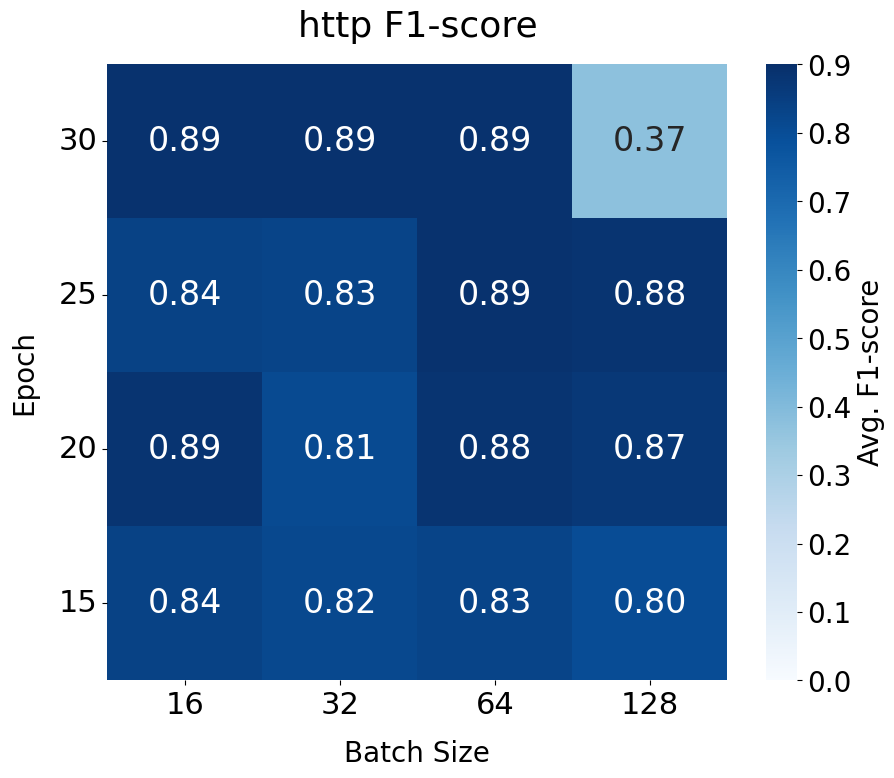

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6599109a0> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs16/2999_model.pth
Model at step 2999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 87.65it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6598f7670> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs32/2999_model.pth
Model at step 2999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 86.29it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a466700> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs64/2999_model.pth
Model at step 2999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 89.73it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6599109a0> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs128/2999_model.pth
Model at step 2999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 91.05it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6598f7670> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs16/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 91.60it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a4bb670> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs32/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 58.22it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd65990f790> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs64/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 76.96it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e03c5100> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs128/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 89.74it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd65990f670> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs16/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 88.07it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd81922f820> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs32/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 88.29it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6595743d0> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs64/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 89.69it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd659541340> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs128/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 88.32it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6783abac0> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs16/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 86.96it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7eaef70> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs32/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 89.24it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7dcafd0> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs64/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 90.04it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (6981, 26, 26, 3)
dataset_data (45963, 26, 26, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1848
dataset_data (1848, 26, 26, 3)
dataset_data (10625, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e03ab490> lb_dset 6981
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_tls_extra_ep250_bs128/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 52.34it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

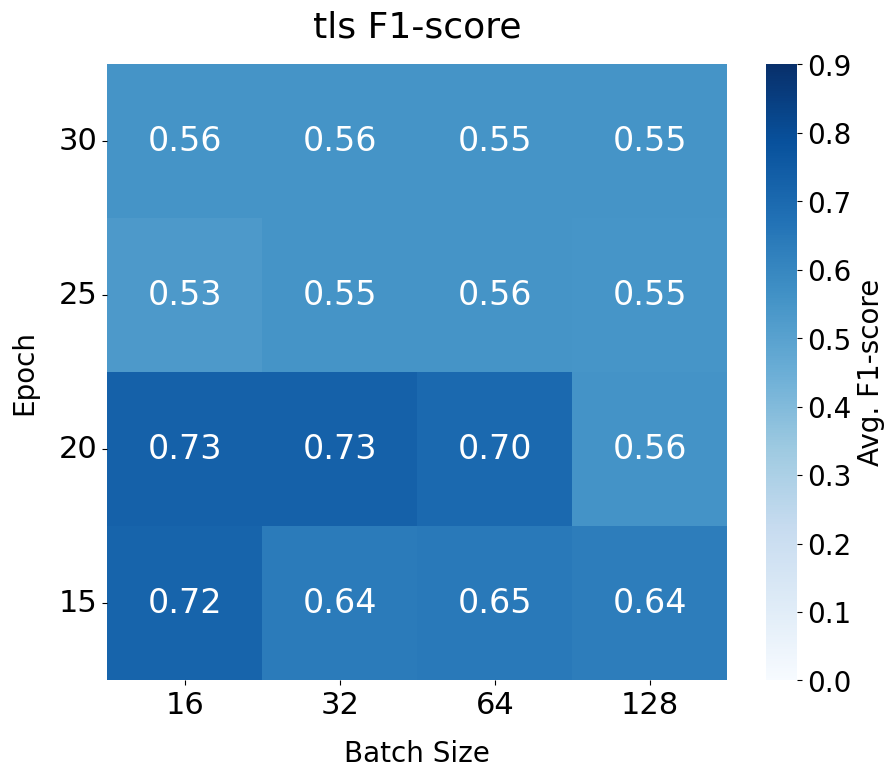

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e022f190> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs16/2999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 58.66it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7dcadc0> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs32/2999_model.pth
Model at step 2999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 63.40it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e73eafa0> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs64/2999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 2999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 62.57it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd819364580> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs128/2999_model.pth
Model at step 2999 loaded!


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
100%|████████████████████████████████████████

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e01def40> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs16/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 56.95it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd6598f7670> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs32/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 64.23it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7eaef70> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs64/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 61.18it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e412a580> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs128/2499_model.pth
Model at step 2499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 62.68it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e07d5700> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs16/1999_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 56.73it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e731c190> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs32/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 56.55it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7dcadc0> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs64/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 57.94it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd73a4bb670> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs128/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 63.97it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e03fefd0> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs16/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 62.80it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e01def40> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs32/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 62.50it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e73eafa0> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs64/1499_model.pth


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Model at step 1499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 62.56it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

dataset_name merge_month_2_4_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1142, 16, 16, 3)
dataset_data (12379, 16, 16, 3)
len_seen_indices 273
dataset_data (273, 16, 16, 3)
dataset_data (4283, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7e412a580> lb_dset 1142
./saved_models/openset_cv/iomatch_selfdeploy_merge_month_2_4_2weektest_dns_extra_ep250_bs128/1499_model.pth
Model at step 1499 loaded!


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 57.38it/s]
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize(

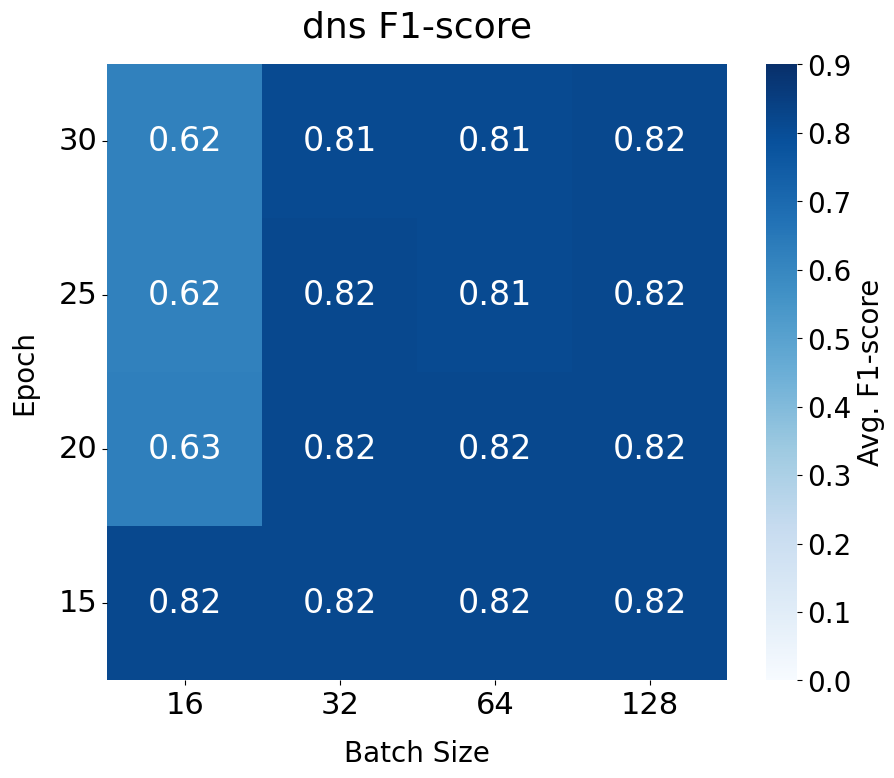

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
dataset_name='SelfDeploy25'


for protocol in ['http','tls','dns']:
    if(dataset_name=='SelfDeploy24'):
        dataset='selfdeploy_merge_month_2_4_2weektest'
    if(dataset_name=='SelfDeploy25'):
        dataset='selfdeploy_24_25_fulldata_2weektest'
    config_name='iomatch_exp_'+dataset+'_'+protocol+'.yaml'#iomatch_cifar10_14000_28class_exp_month2_4_http_perservice_40dayscompletetrain_second
    args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])#test5#iomatch_cifar10_150_eval_25_n#iomatch_cifar10_14000_15class_comp_1
    over_write_args_from_file(args, args.c)#iomatch_cifar10_300_13_2class_comp_1#iomatch_cifar10_14000_13_2class_comp_1
    args.data_dir = 'data'
    total_epoch=250
    epoch_list=[30,25,20,15]#,50,75,100,150,200,250
    batch_size_list=[16,32,64,128]
    
    results = np.zeros((len(epoch_list), len(batch_size_list)))
    for i,current_epoch in enumerate(epoch_list):
        for j,batch_size in enumerate(batch_size_list):
            args.bsz = batch_size
            args.load_path = "./saved_models/openset_cv/iomatch_"+dataset+"_"+protocol+"_extra_ep"+str(total_epoch)+"_bs"+str(batch_size)+"/latest_model.pth"
            dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
            best_net = load_model_at(str(current_epoch*100-1))#latest
            eval_dict = evaluate_io(args, best_net, dataset_dict)
            
            
            label_list=eval_dict['label_list']

            labels=label_list
            
            labels_x=label_list[:-3]+['unknown']
            


            value_to_delete = 26
            

            mask = eval_dict['y_true'] != value_to_delete
            filtered_y_true = eval_dict['y_true'][mask]
            filtered_pred_q = eval_dict['pred_q'][mask]
            filtered_y_true[filtered_y_true >25]=25
            
            report=classification_report(filtered_y_true,filtered_pred_q)#,target_names=label_list[:-5]+['driftnet+censys(added in unknown)'])
            #print(report)
            
            
            f1_score_test=f1_score(filtered_y_true,filtered_pred_q,average='weighted')
            #print('f1_score_weighted',f1_score_test)
    
            results[i, j] = f1_score_test
    
    
    
    plt.figure(figsize=(10, 8))  
    
    data = results
    row_labels = epoch_list#['250', '200', '150', '100']  
    col_labels = batch_size_list     
    
    
    heatmap = sns.heatmap(
        data,
        annot=True,                
        fmt=".2f",                 
        cmap="Blues",              
        linewidths=0,              
        linecolor="white",         
        xticklabels=col_labels,
        yticklabels=row_labels,
        annot_kws={"size": 24},
        cbar_kws={'label': 'Accuracy'},  
        vmin=0,
        vmax=0.9
    )
    
    
    plt.title(protocol+" F1-score", fontsize=26, pad=20)
    plt.xlabel("Batch Size", fontsize=20, labelpad=15)
    plt.ylabel("Epoch", fontsize=20, labelpad=15)
    
    
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0, fontsize=22)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=22)
    
    
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label("Avg. F1-score", fontsize=20)
    
    plt.show()

dataset_name selfdeploy_24_25_2week
data_dir data/cifar10
num_labels 2500 num_classes 25 this mode use all samples
dataset_data (5054, 23, 23, 3)
dataset_data (71006, 23, 23, 3)


/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 1378
dataset_data (1378, 23, 23, 3)
dataset_data (23555, 23, 23, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd8191a0f40> lb_dset 5054
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_http_extra_ep250_bs64/1999_model.pth
Model at step 1999 loaded!


100%|██████████████████████████████████████████| 93/93 [00:00<00:00, 120.13it/s]


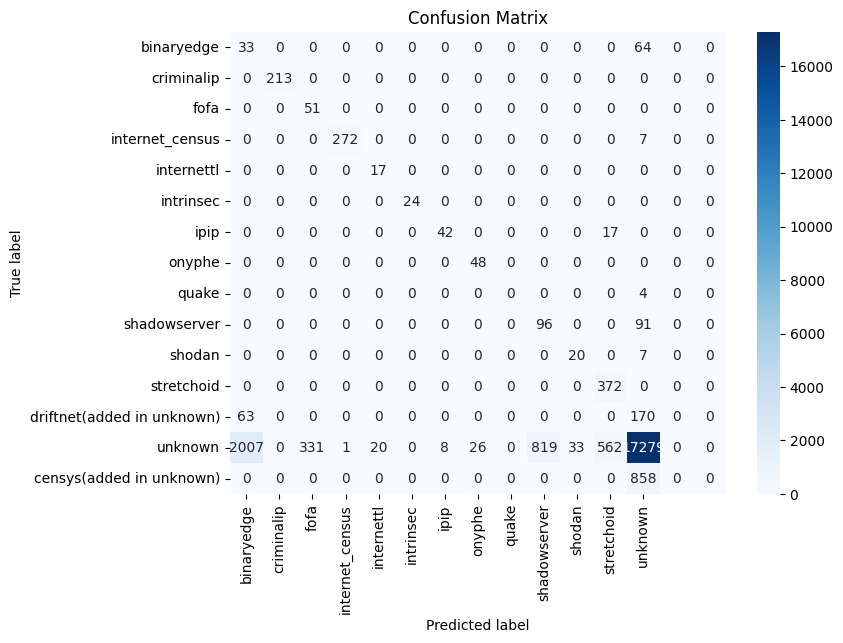

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           4       0.34      0.34      0.34        97
           5       1.00      1.00      1.00       213
           7       1.00      1.00      1.00        51
           8       1.00      0.97      0.99       279
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        24
          11       1.00      0.71      0.83        59
          13       1.00      1.00      1.00        48
          15       0.00      0.00      0.00         4
          18       1.00      0.51      0.68       187
          19       1.00      0.74      0.85        27
          20       0.96      1.00      0.98       372
          25       0.86      0.94      0.90      1091

    accuracy                           0.90      2469
   macro avg       0.86      0.79      0.81      2469
weighted avg       0.90      0.90      0.89      2469

f1_score_weighted 0.8922223030099097
23555
       prediction               ip  

/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


len_seen_indices 2674
dataset_data (2674, 26, 26, 3)
dataset_data (16296, 26, 26, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd7d7b34ca0> lb_dset 8681
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_tls_extra_ep250_bs64/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 64/64 [00:00<00:00, 65.59it/s]


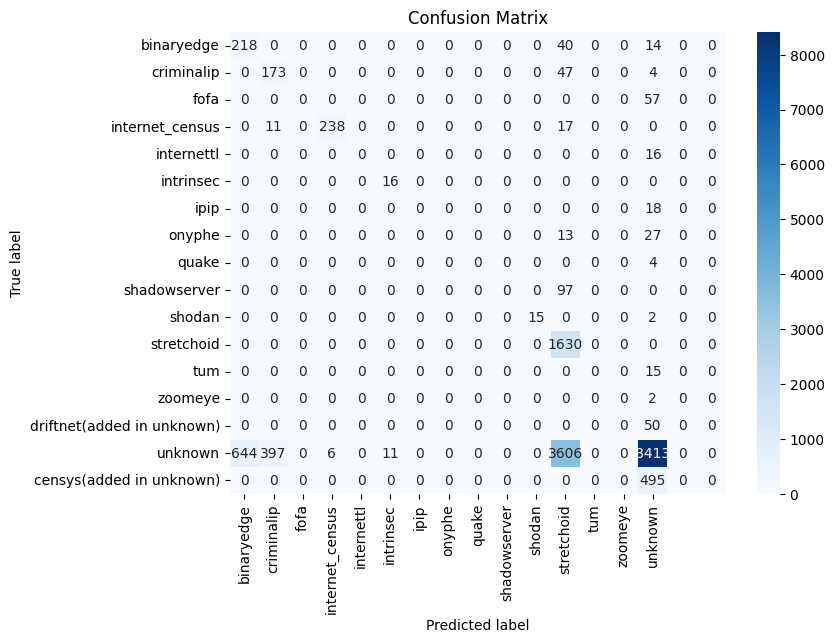

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           4       1.00      0.80      0.89       272
           5       0.94      0.77      0.85       224
           7       0.00      0.00      0.00        57
           8       1.00      0.89      0.94       266
           9       0.00      0.00      0.00        16
          10       1.00      1.00      1.00        16
          11       0.00      0.00      0.00        18
          13       0.00      0.00      0.00        40
          15       0.00      0.00      0.00         4
          18       0.00      0.00      0.00        97
          19       1.00      0.88      0.94        17
          20       0.88      1.00      0.94      1630
          21       0.00      0.00      0.00        15
          24       0.00      0.00      0.00         2
          25       0.77      1.00      0.87       545

    accuracy                           0.88      3219
   macro avg       0.44      0.42      0.43      3219
weighted avg       0.82   

/tmp/ipykernel_1232051/4148006837.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


num_labels 2500 num_classes 25 this mode use all samples
dataset_data (1127, 16, 16, 3)
dataset_data (20354, 16, 16, 3)
len_seen_indices 327
dataset_data (327, 16, 16, 3)
dataset_data (5291, 16, 16, 3)
lb_dset <semilearn.datasets.cv_datasets.datasetbase.BasicDataset object at 0x7fd81855e0d0> lb_dset 1127
./saved_models/openset_cv/iomatch_selfdeploy_24_25_fulldata_2weektest_dns_extra_ep250_bs64/1999_model.pth
Model at step 1999 loaded!


100%|███████████████████████████████████████████| 21/21 [00:00<00:00, 63.50it/s]


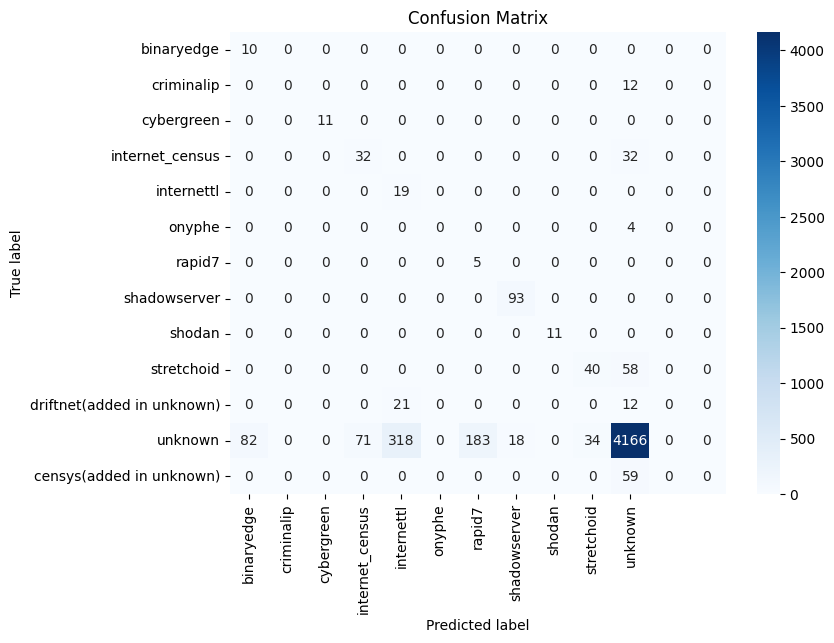

/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           4       1.00      1.00      1.00        10
           5       0.00      0.00      0.00        12
           6       1.00      1.00      1.00        11
           8       1.00      0.50      0.67        64
           9       0.47      1.00      0.64        19
          13       0.00      0.00      0.00         4
          16       1.00      1.00      1.00         5
          18       1.00      1.00      1.00        93
          19       1.00      1.00      1.00        11
          20       1.00      0.41      0.58        98
          25       0.40      0.77      0.53        92

    accuracy                           0.70       419
   macro avg       0.72      0.70      0.67       419
weighted avg       0.81      0.70      0.69       419

f1_score_weighted 0.692793806127065
5291
      prediction              ip  groundtruth
0              4  167.99.227.103            4
1              4   50.116.53.243            4
2       

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import pandas as pd
import pickle

dataset_name='SelfDeploy25'


for protocol in ['http','tls','dns']:
    if(dataset_name=='SelfDeploy24'):
        dataset='selfdeploy_merge_month_2_4_2weektest'
        name='merge_month_2_4_2week'
    if(dataset_name=='SelfDeploy25'):
        dataset='selfdeploy_24_25_fulldata_2weektest'
        name='selfdeploy_24_25_2week'
    
    config_name='iomatch_exp_'+dataset+'_'+protocol+'.yaml'
    args = parser.parse_args(args=['--c', 'config/openset_cv/iomatch/'+config_name])#test5#iomatch_cifar10_150_eval_25_n#iomatch_cifar10_14000_15class_comp_1
    over_write_args_from_file(args, args.c)#iomatch_cifar10_300_13_2class_comp_1#iomatch_cifar10_14000_13_2class_comp_1
    args.data_dir = 'data'
    total_epoch=250
    current_epoch=20
    batch_size=64
    
    args.bsz = batch_size
    args.load_path = "./saved_models/openset_cv/iomatch_"+dataset+"_"+protocol+"_extra_ep"+str(total_epoch)+"_bs"+str(batch_size)+"/latest_model.pth"
    dataset_dict = get_dataset(args, args.algorithm, args.dataset, args.num_labels, args.num_classes, args.data_dir, eval_open=False)
    best_net = load_model_at(str(current_epoch*100-1))#latest
    eval_dict = evaluate_io(args, best_net, dataset_dict)
    
    
    label_list=eval_dict['label_list']
    #,'CriminalIP',
    labels=label_list
    
    labels_x=label_list[:-3]+['unknown']
    
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(eval_dict['o_cfmat_f_q'], annot=True, cmap='Blues', fmt='g',xticklabels=labels_x,yticklabels=labels)#, xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1']
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    
    
    value_to_delete = 26
    
    
    mask = eval_dict['y_true'] != value_to_delete
    filtered_y_true = eval_dict['y_true'][mask]
    filtered_pred_q = eval_dict['pred_q'][mask]
    filtered_y_true[filtered_y_true >25]=25
    
    report=classification_report(filtered_y_true,filtered_pred_q)#,target_names=label_list[:-5]+['driftnet+censys(added in unknown)'])
    print(report)
    
    
    f1_score_test=f1_score(filtered_y_true,filtered_pred_q,average='weighted')
    print('f1_score_weighted',f1_score_test)
    
    
    
    
    
    
    
    if('http' in config_name):
        proto='http'
    if('tls' in config_name):
        proto='tls'
    if('dns' in config_name):
        proto='dns'
    if('ssh' in config_name):
        proto='ssh'
    if('rdp' in config_name):
        proto='rdp'
        
    mode='test'
    npy_path1 = '../dataset/npy/ip_array_'+proto+'_'+name+'_'+mode+'.npy'
    #npy_path2 = 'label_array_'+proto+'_'+name+'_'+mode+'.npy'
    #dataset = NumpyDataset(npy_path1,npy_path2)
    
    loaded_array = np.load(npy_path1,allow_pickle=True)
    loaded_array
    print(len(loaded_array))
    #print(len(y_true))
    mask = ~np.isin(loaded_array, ['192.168.1.0', '192.168.2.0','192.168.3.0','192.168.4.0','192.168.5.0'])
    loaded_array = loaded_array[mask]
    
    pred = eval_dict['pred_q']
    pred = pred[mask]
    
    y_true = eval_dict['y_true']
    y_true = y_true[mask]
    
    
    #pred = eval_dict['pred_q']
    #y_true = eval_dict['y_true']
    
    
    df = pd.DataFrame({'prediction': pred, 'ip': loaded_array,'groundtruth':y_true})
    
    print(df)
    
    df.to_csv('result_'+proto+'_'+name+'_'+mode+'.csv', index=False)

    
    test_dns_label_dic = {}
    for value, group_df in df.groupby('ip'):
        test_dns_label_dic[value] = group_df
        
    test_dns_label_dic_common={}
    for i in test_dns_label_dic.keys():
        test_dns_label_dic_common[i]=test_dns_label_dic[i]['prediction'].mode().values[0]
    
    def protocol_level_prediciton(ip_train2,y_train2,train2_label_dic_common):
        a=pd.DataFrame()
        a['ip']=ip_train2
        a['label']=y_train2
        a['pred_label']=None
        a=a.drop_duplicates()
        for index, row in a.iterrows():
            a.loc[index,'pred_label']=train2_label_dic_common[row['ip']]
        #print(a)
        return a
    df_ip_dns_test=protocol_level_prediciton(loaded_array,y_true,test_dns_label_dic_common)
    df_ip_dns_test=df_ip_dns_test.rename(columns={'pred_label':'pred_label_'+proto})
    
    print(df_ip_dns_test)
    with open('proto_level_pred_'+proto+'_'+name+'_'+mode+'.pkl', 'wb') as f:
        pickle.dump(df_ip_dns_test, f)
     

